In [1]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/255.0
X_test = X_test/255.0

X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

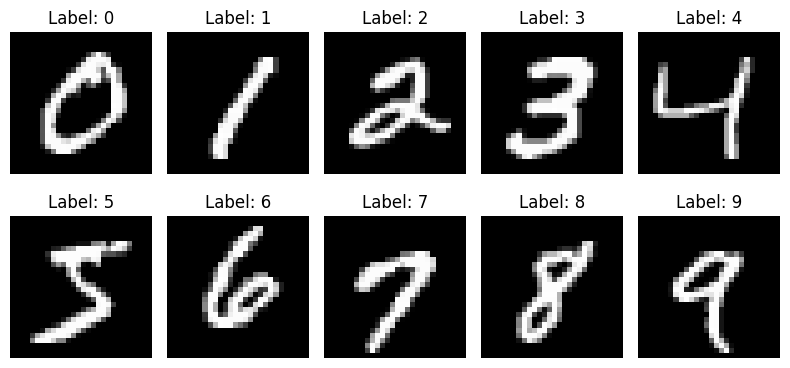

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(8, 4))

for label in range(10):
    row = label // 5  # Dòng (0 hoặc 1)
    col = label % 5   # Cột (0 đến 4)
    
    image_for_label = X_train[y_train == label][0]
    
    axes[row, col].imshow(image_for_label, cmap='gray')
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

In [4]:
X_train_vecto = X_train.reshape(60000, 784)
X_test_vecto = X_test.reshape(10000, 784)
X_vecto = X.reshape(70000, 784)

## Giảm chiều dữ liệu

In [5]:
pca_2 = PCA(n_components=2)
X_2D = pca_2.fit_transform(X_vecto)

# Giữ lại được % dữ liệu ban đầu:
explained_variance_ratio = pca_2.explained_variance_ratio_
total_variance_ratio = np.sum(explained_variance_ratio)
print(total_variance_ratio)

0.16901560506729174


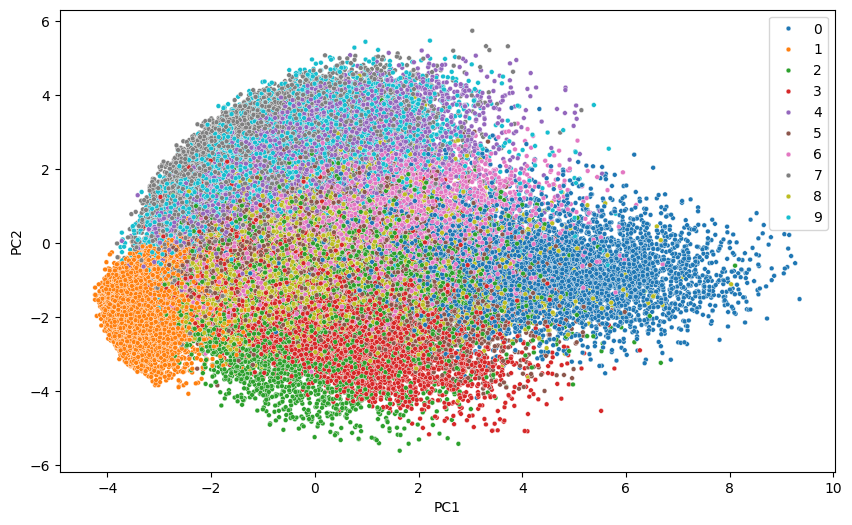

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2D[:, 0], y=X_2D[:, 1], hue=y, palette='tab10', s=12)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [7]:
pca_3 = PCA(n_components=3)
X_3D = pca_3.fit_transform(X_vecto)
# Giữ lại được % dữ liệu ban đầu:
explained_variance_ratio_3d = pca_3.explained_variance_ratio_
total_variance_ratio_3d = np.sum(explained_variance_ratio_3d)
print(total_variance_ratio_3d)

0.2305109147580879


## Phân cụm Kmeans

In [8]:
# Hiển thị dữ liệu phân cụm Kmeans lên mặt phẳng
def kmeans_display(X, label, centers):
    K = len(centers)

    plt.figure(figsize=(10,6))
    markers = plt.Line2D.markers.keys()
    markers = list(markers)
    for k in range(K):
        Xk = X[label == k, :]
        plt.scatter(Xk[:, 0], Xk[:, 1], marker = markers[k], color=sns.color_palette('tab10')[k], label=f'Cluster {k}', s=12)
    
    for i, center in enumerate(centers):
        plt.scatter(center[0], center[1], marker = markers[i], color='black', s=100)

    plt.legend()
    plt.title('KMeans Clustering')
    plt.show()

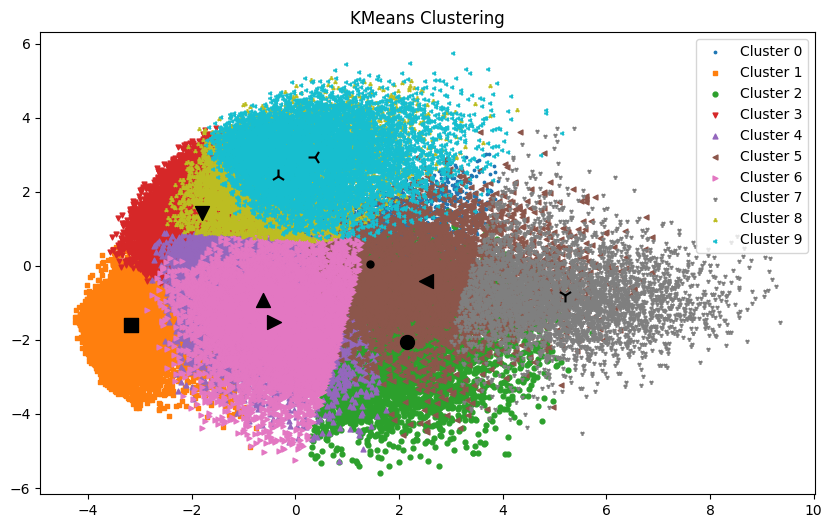

In [9]:
# K-Means
## Dữ liệu gốc
start_time_kmeans = time.time()
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans_labels = kmeans.fit_predict(X_vecto)
end_time_kmeans = time.time()
elapsed_time_kmeans = end_time_kmeans - start_time_kmeans

## Dữ liệu sau giảm chiều
k = KMeans(n_clusters=10).fit(X_3D)
cluster_labels = k.predict(X_3D)
cluster_centers = k.cluster_centers_
kmeans_display(X_3D, cluster_labels, cluster_centers)

## Phân cụm EM (GMM)

In [10]:
def gmm_display(X, labels, title):
    K = len(np.unique(labels))
    plt.figure(figsize=(10, 6))
    markers = plt.Line2D.markers.keys()
    markers = list(markers)
    for k in range(K):
        Xk = X[labels == k, :]
        plt.scatter(Xk[:, 0], Xk[:, 1], marker=markers[k % len(markers)], color=sns.color_palette('tab10')[k], label=f'Cluster {k}', s=12)
    plt.legend()
    plt.title(title)
    plt.show()

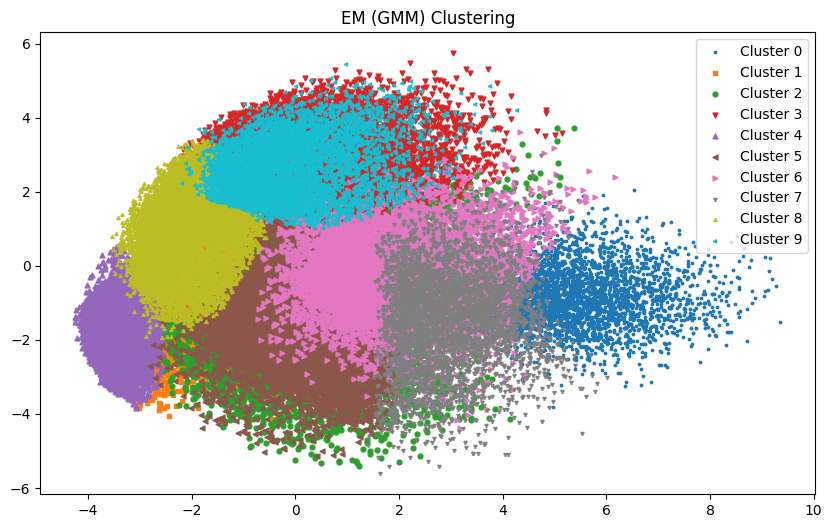

In [11]:
# GMM
## Dữ liệu gốc
start_time_gmm = time.time()
gmm = GaussianMixture(n_components=10, covariance_type='diag',random_state=0)
gmm.fit(X_vecto)
gmm_labels = gmm.fit_predict(X_vecto)
end_time_gmm = time.time()
elapsed_time_gmm = end_time_gmm - start_time_gmm

## Dữ liệu sau giảm chiều
gmm.fit(X_3D)
cluster_labels = gmm.predict(X_3D)
gmm_display(X_3D, cluster_labels, 'EM (GMM) Clustering')

In [12]:
# Thông số so sánh
print(f"Time taken for K-means clustering: {elapsed_time_kmeans:.2f} seconds")
print(f"Time taken for GMM clustering: {elapsed_time_gmm:.2f} seconds")

# Evaluation metrics
kmeans_ari = adjusted_rand_score(y, kmeans_labels)
gmm_ari = adjusted_rand_score(y, gmm_labels)

kmeans_silhouette = silhouette_score(X_vecto, kmeans_labels)
gmm_silhouette = silhouette_score(X_vecto, gmm_labels)

print(f"KMeans Adjusted Rand Index (ARI): {kmeans_ari:.4f}")
print(f"Gaussian Mixture Model Adjusted Rand Index (ARI): {gmm_ari:.4f}")

print(f"KMeans Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Gaussian Mixture Model Silhouette Score: {gmm_silhouette:.4f}")

Time taken for K-means clustering: 4.13 seconds
Time taken for GMM clustering: 69.65 seconds
KMeans Adjusted Rand Index (ARI): 0.3609
Gaussian Mixture Model Adjusted Rand Index (ARI): 0.1768
KMeans Silhouette Score: 0.0586
Gaussian Mixture Model Silhouette Score: 0.0045


## Mô hình Multinomial Logistic Regression (Softmax)

In [13]:
from sklearn.linear_model import LogisticRegression

softmax_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=0)
softmax_model.fit(X_train_vecto, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)

In [14]:
y_pred = softmax_model.predict(X_test_vecto)

print('Accuracy (Softmax):', accuracy_score(y_test, y_pred))
print("Precision (Softmax) (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (Softmax) (macro):", recall_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy (Softmax): 0.9261
Precision (Softmax) (macro): 0.9251419508761632
Recall (Softmax) (macro): 0.9250437312833446
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.89       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



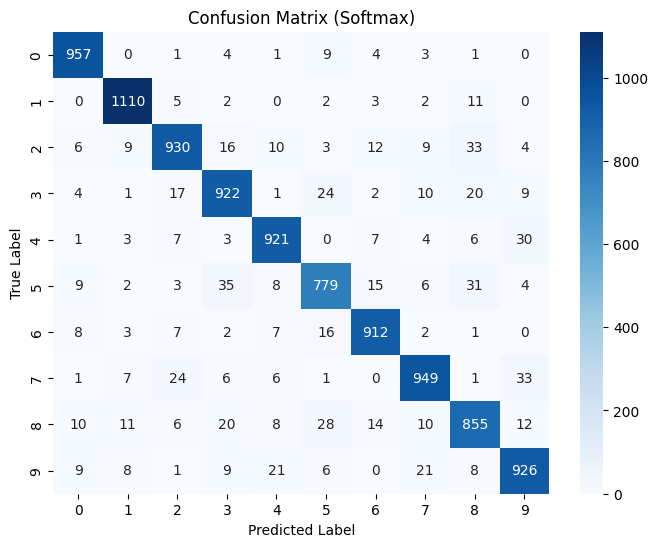

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix (Softmax)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Mô hình CNN

In [16]:
cnn_model = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(10, activation='softmax')
])

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,882 (624.54 KB)

 Trainable params: 159,882 (624.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=10,
    verbose=1)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.7382 - loss: 0.7822 - val_accuracy: 0.9756 - val_loss: 0.0783
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.9707 - loss: 0.1014 - val_accuracy: 0.9762 - val_loss: 0.0829
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9799 - loss: 0.0668 - val_accuracy: 0.9828 - val_loss: 0.0552
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9847 - loss: 0.0531 - val_accuracy: 0.9842 - val_loss: 0.0514
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9880 - loss: 0.0396 - val_accuracy: 0.9880 - val_loss: 0.0444
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9896 - loss: 0.0354 - val_accuracy: 0.9858 - val_loss: 0.0545
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9899 - loss: 0.0296 - val_accuracy: 0.9892 - val_loss: 0.0392
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9929 - loss: 0.0227 - 

Text(0.5, 1.0, 'Training and validation loss')

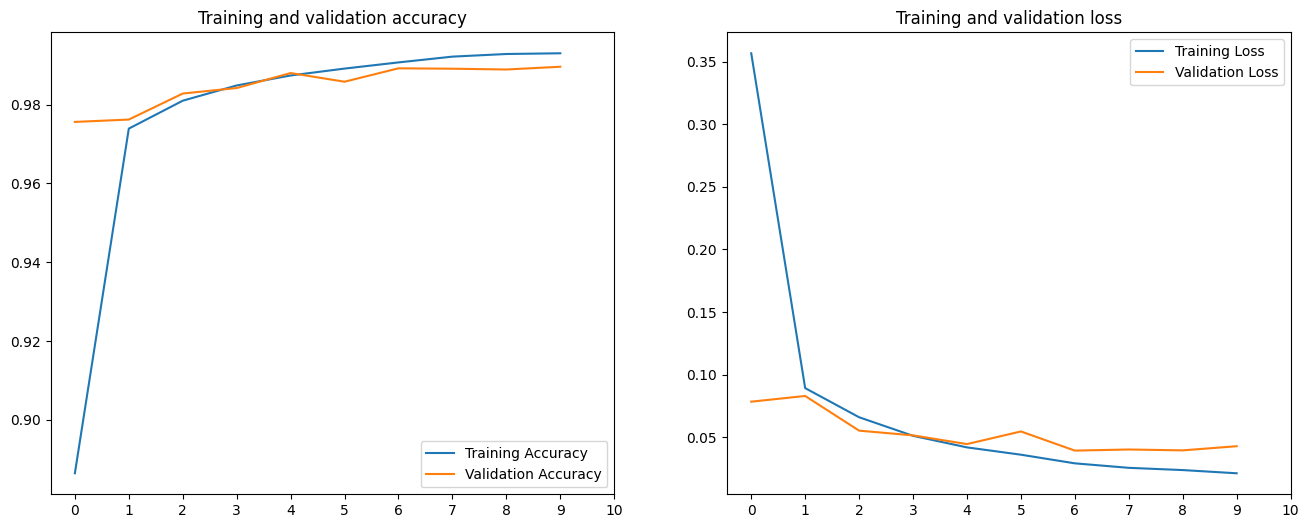

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(acc)

plt.figure(figsize=(16, 6))

# Đồ thị accuracy trên tập train và tập validation
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xticks(range(0, epochs+1, 1))
plt.legend()

# Đồ thị hàm loss trên tập train và tập validation
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(range(0, epochs+1, 1))
plt.legend()
plt.title('Training and validation loss')

In [19]:
y_pred = np.argmax(cnn_model.predict(X_test), axis = 1)

print("Accuracy (CNN): ", accuracy_score(y_test, y_pred))
print("Precision (CNN) (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (CNN) (macro):", recall_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy (CNN):  0.9896
Precision (CNN) (macro): 0.989647425630317
Recall (CNN) (macro): 0.9895282169355657
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



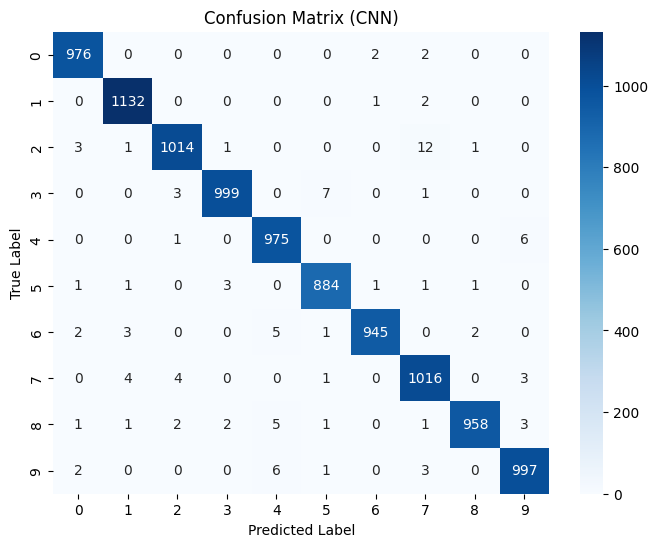

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Mô hình Multi-Class SVM

In [21]:
# method to compute loss function and its gradient
# here vectorization was used to speed up
def svm_loss_vectorized(W, X, y, reg):
    d, C = W.shape 
    _, N = X.shape 
    loss = 0 
    dW = np.zeros_like(W)
    
    Z = W.T.dot(X)     
    
    correct_class_score = np.choose(y, Z).reshape(N,1).T     
    margins = np.maximum(0, Z - correct_class_score + 1) 
    margins[y, np.arange(margins.shape[1])] = 0
    loss = np.sum(margins, axis = (0, 1))
    loss /= N 
    loss += 0.5 * reg * np.sum(W * W)
    
    F = (margins > 0).astype(int)
    F[y, np.arange(F.shape[1])] = np.sum(-F, axis = 0)
    dW = X.dot(F.T)/N + reg*W
    return loss, dW

In [53]:
# Mini-batch gradient descent

def multiclass_svm_GD(X, y, C, reg=0.02, lr=0.1, batch_size=200, num_iters=2000, print_every=100):
    d, N = X.shape
    W_init = np.random.randn(d + 1, C)  # Initialize with bias term
    W = W_init
    loss_history = np.zeros((num_iters))

    for it in range(num_iters):
        # randomly pick a batch of X
        idx = np.random.choice(N, batch_size)
        X_batch = np.concatenate((X[:, idx], np.ones((1, batch_size))), axis=0)
        y_batch = y[idx]

        loss_history[it], dW = svm_loss_vectorized(W, X_batch, y_batch, reg)

        W -= lr * dW
        # if it % print_every == 0:
        #     print('it %d/%d, loss = %f' % (it, num_iters, loss_history[it]))

    return W, loss_history

def predict(X, W):
    # Add bias term to X
    X = np.concatenate((X, np.ones((1, X.shape[1]))), axis=0)
    scores = W.T.dot(X)
    y_pred = np.argmax(scores, axis=0)
    return y_pred

In [54]:
# Train the model
learning_rates = [1e-1, 2e-1, 1e-2, 2e-2, 1e-3, 2e-3]
regularization_strengths = [1e-1, 2e-1, 1e-2, 2e-2, 1e-3, 2e-3, 1e-4, 2e-4]

best_acc = -1
best_W = None
best_lr_r = ()
for l in learning_rates:
    for r in regularization_strengths:

        W, loss_history = multiclass_svm_GD(X_train_vecto.T, y_train, C=10, reg=r, lr=l)
        y_pred_svm = predict(X_test_vecto.T, W)
        acc = accuracy_score(y_test, y_pred_svm)
        print(f"(lr, reg) = ({l}, {r}): acc = {acc}, loss = {loss_history[-1]:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_W = W
            best_lr_r = (l,r)

(lr, reg) = (0.1, 0.1): acc = 0.88, loss = 0.9082
(lr, reg) = (0.1, 0.2): acc = 0.8462, loss = 1.7218
(lr, reg) = (0.1, 0.01): acc = 0.9063, loss = 1.0967
(lr, reg) = (0.1, 0.02): acc = 0.9038, loss = 0.6201
(lr, reg) = (0.1, 0.001): acc = 0.8717, loss = 3.4636
(lr, reg) = (0.1, 0.002): acc = 0.8745, loss = 3.8926
(lr, reg) = (0.1, 0.0001): acc = 0.8652, loss = 1.5027
(lr, reg) = (0.1, 0.0002): acc = 0.8703, loss = 1.3364
(lr, reg) = (0.2, 0.1): acc = 0.855, loss = 1.0040
(lr, reg) = (0.2, 0.2): acc = 0.6498, loss = 3.8160
(lr, reg) = (0.2, 0.01): acc = 0.8998, loss = 0.7602
(lr, reg) = (0.2, 0.02): acc = 0.901, loss = 0.6391
(lr, reg) = (0.2, 0.001): acc = 0.8913, loss = 2.2846
(lr, reg) = (0.2, 0.002): acc = 0.8958, loss = 2.1916
(lr, reg) = (0.2, 0.0001): acc = 0.8797, loss = 1.0168
(lr, reg) = (0.2, 0.0002): acc = 0.877, loss = 1.3007
(lr, reg) = (0.01, 0.1): acc = 0.8716, loss = 7.7451
(lr, reg) = (0.01, 0.2): acc = 0.896, loss = 1.2863
(lr, reg) = (0.01, 0.01): acc = 0.7576, loss

In [55]:
print("Using: (lr, r) = ", best_lr_r)

Using: (lr, r) =  (0.1, 0.01)


In [60]:
y_pred_svm = predict(X_test_vecto.T, best_W)
print("Accuracy (mSVM): ", accuracy_score(y_test, y_pred_svm))
print("Precision (mSVM) (macro):", precision_score(y_test, y_pred_svm, average='macro'))
print("Recall (mSVM) (macro):", recall_score(y_test, y_pred_svm, average='macro'))
print(classification_report(y_test, y_pred_svm))

Accuracy (mSVM):  0.9063
Precision (mSVM) (macro): 0.9078458923309138
Recall (mSVM) (macro): 0.904209691295627
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.97      0.97      1135
           2       0.93      0.86      0.89      1032
           3       0.84      0.93      0.88      1010
           4       0.90      0.93      0.91       982
           5       0.93      0.76      0.84       892
           6       0.91      0.95      0.93       958
           7       0.89      0.93      0.91      1028
           8       0.82      0.90      0.86       974
           9       0.93      0.86      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000



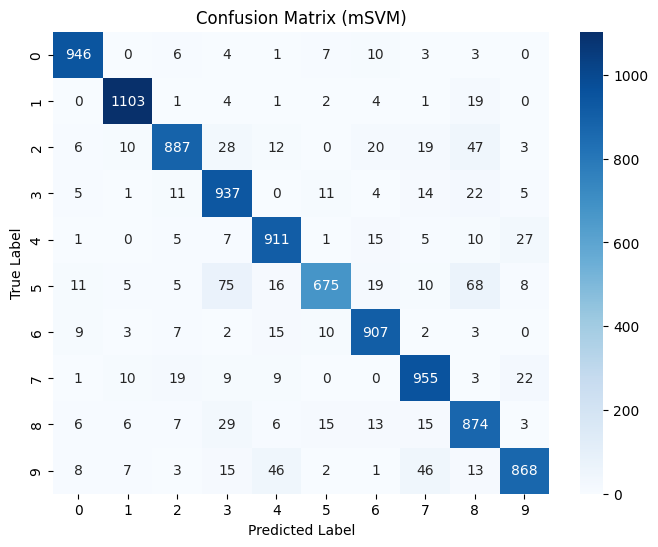

In [58]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix (mSVM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()